## 1. Poisson's Equation

### Preliminaries

We're looking to solve Poisson's equation for electrostatics (given in dimensionless units, so that $\epsilon_{0} = 1$) on an $(N+1) \times (N+1)$ unit grid:

$$
  \Delta \phi = -\rho
$$

Here, $\rho$ is zero except at $\vec{x} = (0.5 + a/2, 0.25 + a/2)$, where it equals $2\delta(\vec{x})$. Since we're including points along the border, the distance between neighboring grid points is $h = 1/N$. We can express the discretized Laplacian, acting on the $N^2$-vector of potentials on the grid, as:

$$
  \Delta_{i,j} \phi_{j} = \frac{-4\phi_{i} + \phi_{i+1} + \phi_{i-1} + \phi_{i+N} + \phi_{i-N}}{h^2}
  = N^2 \Big(-4\phi_{i} + \phi_{i+1} + \phi_{i-1} + \phi_{i+N} + \phi_{i-N}\Big)
$$

so that the Laplacian matrix itself can be expressed in terms of Kronecker deltas as

$$
  \Delta_{i,j} = N^2 \Big(-4\delta_{i,j} + \delta_{i+1,j} + \delta_{i-1,j} + \delta_{i+N,j} + \delta_{i-N,j}\Big)
$$

which, it's worth noting, is a symmetric matrix. 

We have inhomogenous boundary conditions ($\phi = 10$) for the rectangle centered at (0.625, 0.75) and homogenous boundary conditions along the perimeter of the grid. Since these values of $\phi$ are fixed, they cannot figure into the $\Delta\phi=-\rho$ problem, in the sense that $\rho$ cannot be fixed if $\phi$ is held fixed (the equivalent physical analogy is the surface of a conductor in electrostatics). So for any _fixed_ $\phi_{i}$, we can set $\rho_{i} = 0 \implies \Delta_{i,j} = 0 \ \ \forall \ \ j$. In other words, for each $i$ such that $\phi_{i}$ is held constant, we set the $i^{th}$ row of $\Delta$ equal to zero. This assures us that $\phi$ only depends on $\rho$ through the boundary conditions.

Since the conjugate gradient method depends on the symmetry of a matrix, we'll have to deal with the nonzero terms in the $i^{th}$ _column_ of $\Delta$ before zeroing the $i^{th}$ row, which are:

$$
  \Delta_{j,i} = N^2 \Big(-4\delta_{i,j} + \delta_{i,j+1} + \delta_{i,j-1} + \delta_{i,j+N} + \delta_{i,j-N}\Big).
$$

### Implementation

My Laplacian.jl module implements, in order of increasing abstraction:

* ($\delta$ or `kronecker`), __a Kronecker delta matrix function__ that takes arbitrary anonymous functions $f_i$ and $f_j$ (of row and column number, respectively) as arguments, and generates a matrix of arbitrary size whose elements are $\delta_{f_i,f_j}$, allowing for convenient translation of the above formulas
* (`lap`), __a Laplacian matrix function__ that uses `kronecker` along with the above formula for $\Delta$ to produce a Laplacian operator matrix for a square grid, given a particular side length and number of subdivisions in each direction.
* (`findfree`), __a function that produces an array mapping its indices to the free indices of the full matrix__ and which takes as its arguments the size of the full matrix ($N^2$) and a list of indices whose values are fixed as boundary conditions
* (`opsplit`), __a function for splitting $\Delta$ into free and boundary parts__ that takes an $N \times N$ Laplacian matrix (or, in general, a matrix) and an integer array giving the indices of boundary conditions, and returns the tuple ($\Delta_{free}$, $\Delta_{boundary}$) as output.
* (`rhoeff`), __a function for calculating $\rho_{eff}$__ that takes $\rho$, $\Delta_{boundary}$, $\phi_{boundary}$, and an array of the boundary condition indices as input.

My ConjugateGradient module implements:

* (`conjgrad`), __a conjugate gradient solver for $Ax = b$__ that takes $A$, $b$, and (optionally) a starting guess $x_{0}$ as input.

Representing the grid as a 2-d array makes it easier to visualize and easier to specify boundary conditions. I've used Julia's `reshape` function to convert the boundary conditions $\phi_{boundary}$ and the boundary locations $\beta$ to the appropriate 1-d array form.

### Results

The algorithm worked well without the rectangle held at fixed potential:

#### $\phi$ without fixed potential
![Sans rectangle](/Users/Stefan/Dropbox/1-gsas/1st-year/Scientific Computing/Assignments/set05/p1-phi-sans-rectangle.png)

It also worked with the fixed potential:

#### $\phi$ with fixed potential
![With potential, 1](/Users/Stefan/Dropbox/1-gsas/1st-year/Scientific Computing/Assignments/set05/p1-phi.png)
![With potential, 2](/Users/Stefan/Dropbox/1-gsas/1st-year/Scientific Computing/Assignments/set05/p1-phi-2.png)



We can also look at the effect of the number of horizontal grid subdivisions on the values found for the potential at various points:

![phi at (0.25,0.25)](/Users/Stefan/Dropbox/1-gsas/1st-year/Scientific Computing/Assignments/set05/p1phi-0.25-0.25.png)
![phi at (0.375,0.25)](/Users/Stefan/Dropbox/1-gsas/1st-year/Scientific Computing/Assignments/set05/p1phi-0.375-0.25.png)
![phi at (0.5,0.5)](/Users/Stefan/Dropbox/1-gsas/1st-year/Scientific Computing/Assignments/set05/p1phi-0.5-0.5.png)
![phi at (0.875,0.125)](/Users/Stefan/Dropbox/1-gsas/1st-year/Scientific Computing/Assignments/set05/p1phi-0.875-0.125.png)
![phi at (0.875,0.625)](/Users/Stefan/Dropbox/1-gsas/1st-year/Scientific Computing/Assignments/set05/p1phi-0.875-0.625.png)
![phi at (0.875,0.875)](/Users/Stefan/Dropbox/1-gsas/1st-year/Scientific Computing/Assignments/set05/p1phi-0.875-0.875.png)

Clearly, $\phi$ exponentially approaches some continuum value at each point as $N \rightarrow \infty$.

## 2. Free particle Schrodinger equation

Most of the code from question 1 can still be used here. We are now trying to solve Schrodinger's equation,

$$
  E \psi = H \psi,
$$

where $H = -\frac{1}{2m}\Delta + V$ (using our choice of units such that $h=1$) and $V$ is infinite on the border and in the rectangle and is zero elsewhere. Since $m=1/10$, our equation becomes

$$
  -5\Delta \psi = E \psi
$$

within the region where $V = 0$; we can rephrase the infinite potential as a boundary condition on $\psi$, i.e. $\psi=0$ wherever $V \rightarrow \infty$. We can use our earlier code to find the matrix $\Delta_{eff}$ that reflects these boundary conditions. Then, we merely need to find the eigenvalues, which we can approximate using reverse iteration, i.e. through repeated application of the matrix

$$
  A^{-1}_{\mu} \equiv (-5\Delta_{eff} - \mu I)^{-1}
$$

so that, if there are any eigenvalues greater than 1 and close to $\mu$, their corresponding eigenvectors will grow after an application of $A^{-1}_{\mu}$. So, for any $\psi_{0}$ with $\|\psi_{0}\| = 1$, we should have

$$
  \psi_{1}^*\psi_{1} = \|A^{-1}_{\mu} \psi_{0}\|^2 >> 1
$$

whenever $\mu$ is near an eigenvalue. Since $-\Delta_{eff}$ is singular, we can't just invert it. We can, however, use the conjugate gradient method to solve

$$
  A_{\mu} \psi_{1} = \psi_{0}
$$

for $\psi_{1}$. We can then plot $\psi_{1}^*\psi_{1}$ against $\mu$ and look for peaks, which should correspond to eigenvalues of $-5\Delta_{eff}$, i.e. the allowed energies.

In [33]:
include("plot2.jl")
plots = plot2(intrvl);

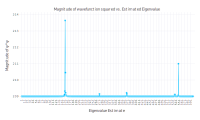

In [34]:
plots[1]

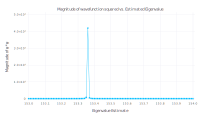

In [29]:
plots[2]

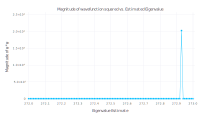

In [30]:
plots[3]

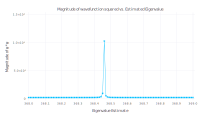

In [31]:
plots[4]

We can use the results from the first graph to narrow our search and get good estimates of the first three energy eigenvalues: $E_{1}=153.36$, $E_{2}=272.93$, and $E_{3}=368.46$. We then use the conjugate gradient method to solve $A_{\mu} \psi_{1} = \psi_{0}$ for $A_{E_{1}}$, $A_{E_{2}}$, and $A_{E_{3}}$, so that (after normalization), $\psi_{1}$ will be nearly parallel to the eigenvector of $-5\Delta_{eff}$ corresponding to eigenvalue $\mu$.

![Ground state](/Users/Stefan/Dropbox/1-gsas/1st-year/Scientific Computing/Assignments/set05/psi1.png)
![First excited state](/Users/Stefan/Dropbox/1-gsas/1st-year/Scientific Computing/Assignments/set05/psi2.png)
![Second excited state](/Users/Stefan/Dropbox/1-gsas/1st-year/Scientific Computing/Assignments/set05/psi3.png)

## 3. Charged particle Schrodinger equation

Introduce a Coulomb potential:

![Coulomb Potential](/Users/Stefan/Dropbox/1-gsas/1st-year/Scientific Computing/Assignments/set05/coulomb.png)

The Schrodinger equation is now

$$
  E\psi = -\frac{1}{2m} \Delta \psi - \frac{q}{r} \psi
$$

where $r$ is the distance from our point charge $q$, which is located at $(0.5 + a/2, 0.25 + a/2)$. Taking $m=1/10$, as before, we are thus looking to solve $H\psi = E\psi$ where $H = -5\Delta - \frac{q}{r}$. $V$ is just a diagonal matrix with entries equal to $1/r$ as measured from the point corresponding to a given row/column.

I made my Lanczos method run for 20 steps before picking the new "best guess" ground state vector, renormalizing it, and restarting, and was able to consistently (and quickly) get results that agreed with each other (as well as Julia's built in eigenvalue functions). For example, for $q=1$, I found $E_{gs} = 159.49$. For $q=10$, $E_{gs} = 209.35$. Plotting the eigenstates for a few values of q, we can see a subtle change in the probability distribution as $q$ increases:

![q = 1](/Users/Stefan/Dropbox/1-gsas/1st-year/Scientific Computing/Assignments/set05/psiq1flat.png)
![q = 5](/Users/Stefan/Dropbox/1-gsas/1st-year/Scientific Computing/Assignments/set05/psiq5flat.png)
![q = 10](/Users/Stefan/Dropbox/1-gsas/1st-year/Scientific Computing/Assignments/set05/psiq10flat.png)
![q = 20](/Users/Stefan/Dropbox/1-gsas/1st-year/Scientific Computing/Assignments/set05/psiq20flat.png)

It seems that the likelihood of the particle being found in the top half of the region is gradually increasing. Intuitively, this makes sense: a steeper Coulombic potential would lead to higher kinetic energy when in the bottom half of the region, near the fixed charge, which means the moving charge would spend comparatively little time in the lower half. This reasoning suggests that the trend of spending more time far from the fixed charge (i.e. in the top half) as $q$ increases is a more general one. To find the probability that the particle is in the bottom half, we can sum up the squares of the components of $\psi$ on the lower half of the region, i.e. for $1 < j < N/2 + 1$, and multiply by the area under each point, namely, $a^2 = 1/N^2$. We can define a function, $F$, that does this for any given values of N and q. Our problem, then, reduces to finding the solution to

$$
  F(N,q) - 0.5 = 0
$$

which we can feed to an equation solver or solve by plotting. Doing so gives $q_{critical}=36.9445$. Comparing $q$ to $F(N,q)$, we see that $F$ is, indeed, decreasing against q:

In [4]:
include("plot3.jl")
plots3 = plot3(intrvls3);

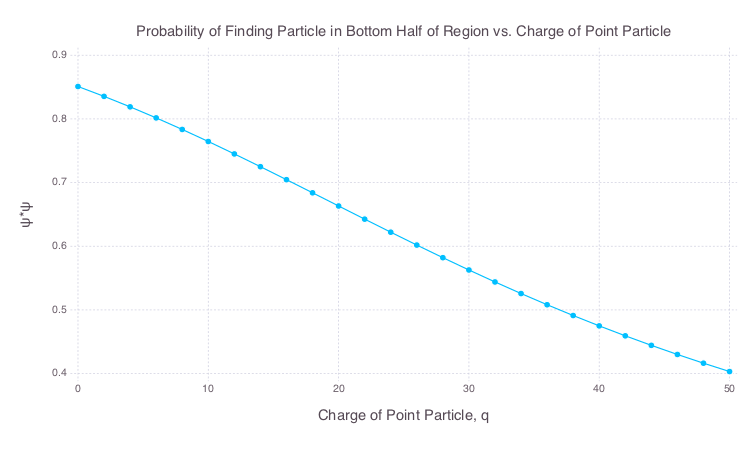

In [5]:
plots3[1]

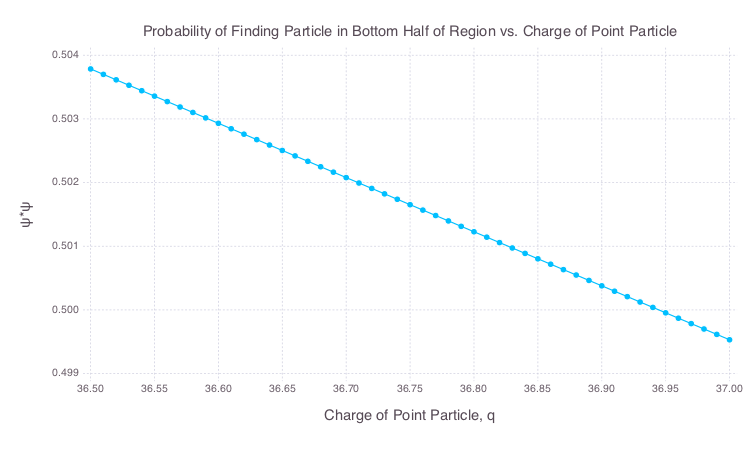

In [7]:
plots3[2]

We can also see the shape of the wavefunction for $q_{critical}=36.9445$:

![q critical = 36.9445](/Users/Stefan/Dropbox/1-gsas/1st-year/Scientific Computing/Assignments/set05/psiqcrit.png)
![q critical = 36.9445](/Users/Stefan/Dropbox/1-gsas/1st-year/Scientific Computing/Assignments/set05/psiqcritflat.png)

A cursory visual inspection supports our solution for q; the probability distribution does indeed seem to be equally split between the top and bottom halves of the region.